In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(rc={"figure.figsize": (12, 8)})
pd.set_option("max_rows", 10)
np.set_printoptions(suppress=True)

Sometimes it can be quite harmful to remove features in a data set. This entry gives an example of when principle component analysis can drastically change the result of a simple linear regression. I am also trying out importing <a href="http://jupyter.org" target="_blank">Jupyter notebooks</a> into this post, so you will see In[] and Out[] tags, which signify the input and output of the notebook.

Suppose there are two variables, A and B, that have a positive correlation of 0.6. There is also a dependent variable Y, determined by Y = A - B, which is unknown. The goal is to obtain the linear relationship, Y = A - B, from data points (a, b, y). To make this more concrete, let's generate some data points with python:

In [2]:
import numpy as np

rho = 0.6 # positive correlation
size = 5000 # number of values

np.random.seed(42) # meaning of life
A = np.random.randn(size)
B = rho * A + np.sqrt(1 - rho**2) * np.random.randn(size)
Y = A - B

We can easily check that the correlation is 0.6:

In [3]:
print(np.corrcoef(A, B))

[[ 1.          0.59371757]
 [ 0.59371757  1.        ]]


To visualize the relationship between A and B:

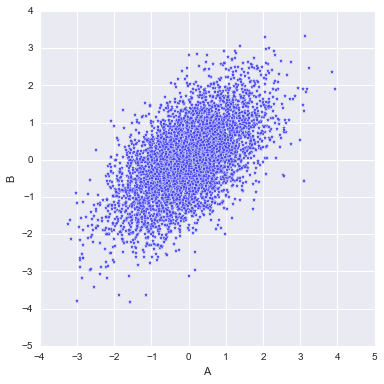

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(A, B, marker='*', c='b')
plt.xlabel('A')
plt.ylabel('B');

Princple Component Analysis (PCA) looks for the directions in A-B space where the data points are more spread out. One can do this in Python like so: 

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.c_[A,B])

PCA(copy=True, n_components=2, whiten=False)

Ploting the two components found by PCA:

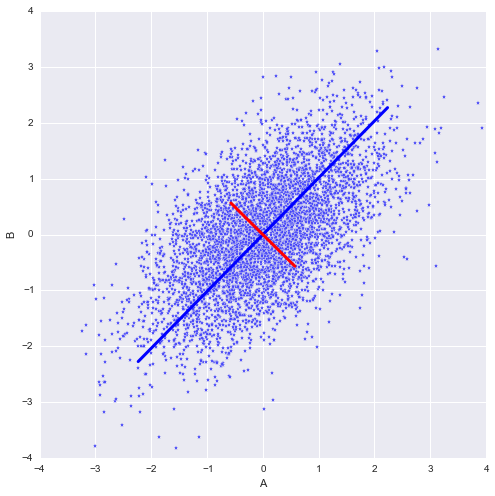

In [6]:
pca_comp = pca.explained_variance_.reshape((2,1)) * pca.components_
pca_cord = np.r_[A.mean(),B.mean()] + pca_comp * 2
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([pca_cord[0][0], -pca_cord[0][0]], [pca_cord[0][1], -pca_cord[0][1]], 'b-', lw=3)
ax.plot([pca_cord[1][0], -pca_cord[1][0]], [pca_cord[1][1], -pca_cord[1][1]], 'r-', lw=3)
ax.scatter(A, B, marker='*', c='b')
ax.set_xbound((-4,4))
ax.set_ybound((-4,4))
ax.set_xlabel('A')
ax.set_ylabel('B');

There is a red and blue direction, and the blue direction explains most of the spread (variance) of the data. How much of the variance is explained by the blue direction? We can compare them with a graph:

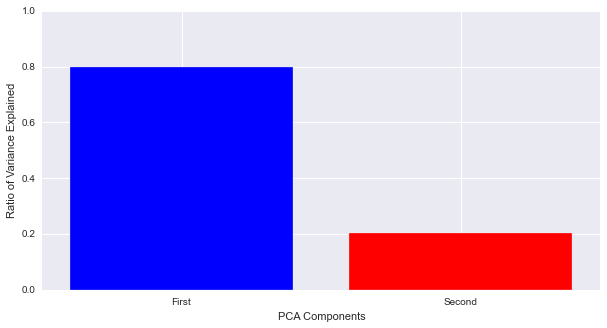

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
width = 0.8
ind = np.arange(len(pca.explained_variance_ratio_)) + (1-width)/2
ax.bar(ind, pca.explained_variance_ratio_, width=width, color=['b', 'r'])
ax.set_ybound((0,1))
ax.set_ylabel('Ratio of Variance Explained')
ax.set_xlabel('PCA Components')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('First', 'Second'));

The first/blue component of PCA explains about 0.8 of the variance, while the second one explains 0.2. The components of the two directions are:

In [8]:
pca.components_

array([[-0.70227741, -0.71190339],
       [-0.71190339,  0.70227741]])

To make the make future formulas shorter, we will estimate 0.7022 as 0.70 amd 0.7119 as 0.71. The calculations in python will keep all significant figures. The transformation from A-B space into these components would be:

$$M = 0.70A+0.71B-(0.70\mu_A + 0.71\mu_B) \\ N = 0.70A-0.71B-(0.70\mu_A - 0.71\mu_B)$$

where $\mu_A$ is the mean of A, $\mu_B$ is the mean of B, M and N are the values in the first and second princple component space.  

Most textbooks/courses would suggest that we can just ignore the second component and use the first princple component. In other words, we will ignore N and keep M. So lets only keep the first component in PCA:

In [9]:
pca_1 = PCA(n_components=1) # keeping only one component
M = pca_1.fit_transform(np.c_[A,B])

Then we perform simple linear regression on this variable:

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(M, Y)
 
# r^2 value
lr.score(M, Y)

0.00018173249112451995

The $r^2$ value of this regression is extremely small. The transformation from variables A and B to M, consist of the sum of A and B, with very close coefficients, in other words our regression model is trying to fit a line to:

$$ Y = \alpha + \beta*M \\ \approx \alpha' + \beta'(A+B)$$

Recall for this example, Y was generated with the formula:

$$ Y = A-B$$

The regression model would never be able to fit and get the correct coefficients because $M\approx A+B$. If we go back and just perform linear regression on the original variables:

In [11]:
lr_orig = LinearRegression()
lr_orig.fit(np.c_[A,B], Y)

# r^2 value
print(lr_orig.coef_)
print(lr_orig.intercept_)
print(lr_orig.score(np.c_[A,B], Y))

[ 1. -1.]
0.0
1.0


We get the values that are consistent with our contrived model for Y. 

One should be careful when performing feature engineering, you may accidentally lose some crucial information.